//PART1//

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/AAX2/Seminar 3'
labels_df = pd.read_csv(data_path + "/labels_data.csv")
rssi_df = pd.read_csv(data_path + "/rssi_data.csv")
print(labels_df.head())
print(rssi_df.head())

Mounted at /content/drive
   5
0  4
1  5
2  2
3  2
4  2
   -21.949  -99.659  -42.257
0  -34.049  -95.964  -47.779
1  -18.861 -100.000  -34.175
2  -53.497  -77.368  -67.360
3  -54.986  -73.012  -69.780
4  -52.012  -84.214  -73.244


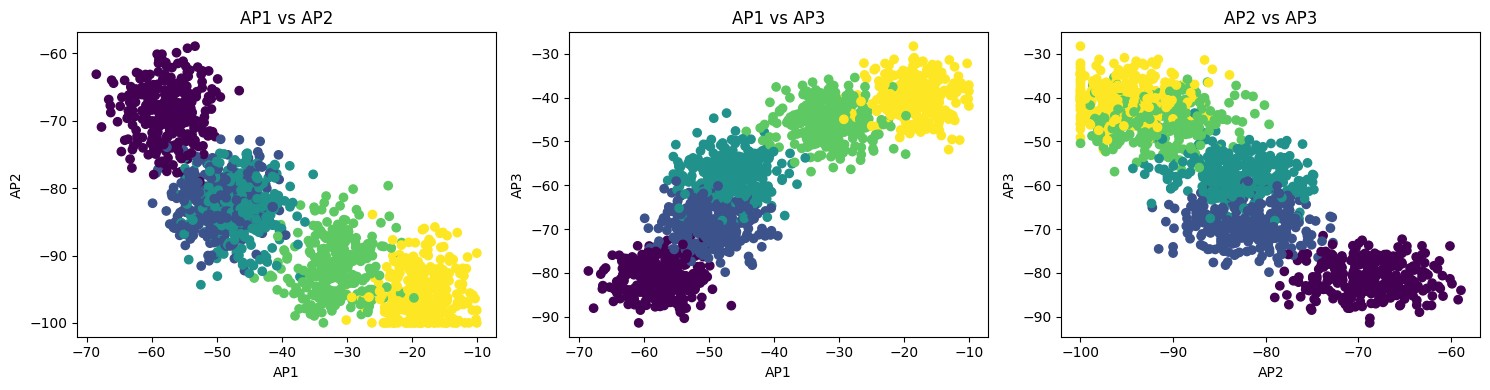

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Make sure columns are labeled properly
rssi_df.columns = ['AP1', 'AP2', 'AP3']
labels_df.columns = ['Location']

# 2D plots: AP1 vs AP2, AP1 vs AP3, AP2 vs AP3
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(rssi_df['AP1'], rssi_df['AP2'], c=labels_df['Location'], cmap='viridis')
plt.xlabel("AP1")
plt.ylabel("AP2")
plt.title("AP1 vs AP2")

plt.subplot(1, 3, 2)
plt.scatter(rssi_df['AP1'], rssi_df['AP3'], c=labels_df['Location'], cmap='viridis')
plt.xlabel("AP1")
plt.ylabel("AP3")
plt.title("AP1 vs AP3")

plt.subplot(1, 3, 3)
plt.scatter(rssi_df['AP2'], rssi_df['AP3'], c=labels_df['Location'], cmap='viridis')
plt.xlabel("AP2")
plt.ylabel("AP3")
plt.title("AP2 vs AP3")

plt.tight_layout()
plt.show()


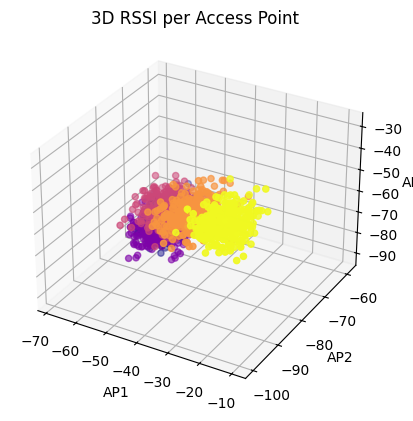

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rssi_df['AP1'], rssi_df['AP2'], rssi_df['AP3'], c=labels_df['Location'], cmap='plasma')

ax.set_xlabel("AP1")
ax.set_ylabel("AP2")
ax.set_zlabel("AP3")
ax.set_title("3D RSSI per Access Point")
plt.show()


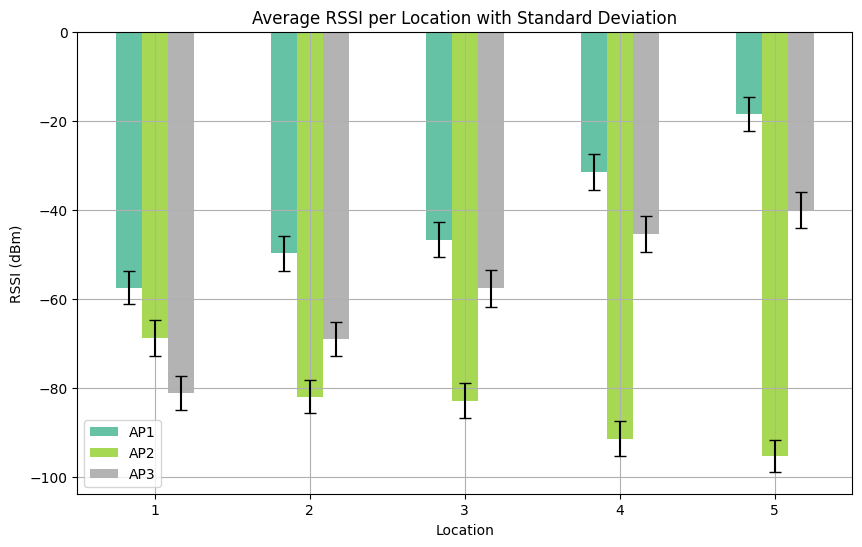

In [5]:
# Concatenate for groupby
combined_df = pd.concat([labels_df, rssi_df], axis=1)

# Group by location
grouped = combined_df.groupby('Location')

# Mean and Std
rssi_mean = grouped.mean()
rssi_std = grouped.std()

# Plotting
rssi_mean.plot(kind='bar', yerr=rssi_std, capsize=4, figsize=(10, 6), colormap='Set2')
plt.title("Average RSSI per Location with Standard Deviation")
plt.ylabel("RSSI (dBm)")
plt.xlabel("Location")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


//PART2//

Converged after 17 iterations.
Final Centroids:
 [[-48.11292699 -82.64319694 -62.92265365]
 [-24.92635798 -93.41807899 -42.73155294]
 [-57.32461587 -69.14226349 -80.8532    ]]


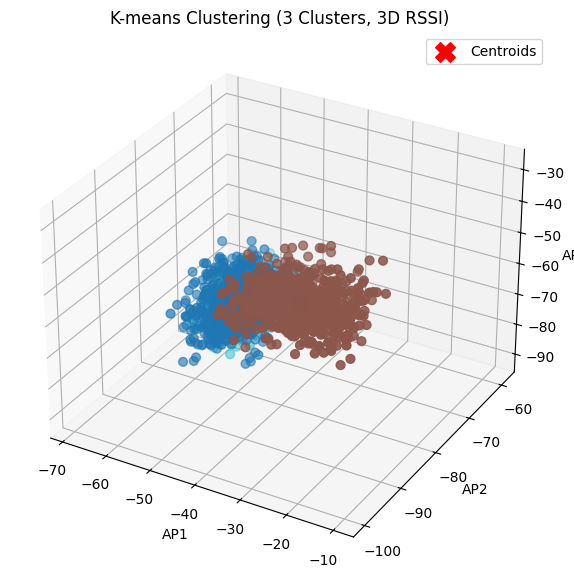

K-means Accuracy: 59.97%


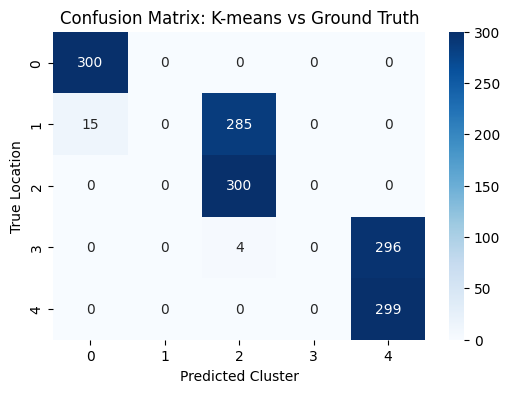

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# --- Data Preparation ---
# Assume rssi_df is already loaded and has columns 'AP1', 'AP2', 'AP3'
X = rssi_df[['AP1', 'AP2', 'AP3']].values
k = 3  # Number of clusters
T = 100  # Max iterations
epsilon = 1e-4  # Convergence threshold

# --- Centroid Initialization (random from data) ---
np.random.seed(42)
centroids = X[np.random.choice(X.shape[0], k, replace=False)]

# --- K-means Algorithm ---
for t in range(T):
    # Assign each point to the closest centroid
    distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    labels = np.argmin(distances, axis=1)

    # Update centroids as the mean of assigned points
    new_centroids = np.array([
        X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
        for i in range(k)
    ])

    # Convergence check: centroids move less than epsilon
    if np.linalg.norm(new_centroids - centroids) < epsilon:
        print(f"Converged after {t+1} iterations.")
        break

    centroids = new_centroids
else:
    print("Reached max iterations without full convergence.")

print("Final Centroids:\n", centroids)

# --- 3D Plot of Cluster Assignments ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='tab10', s=40)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('AP1')
ax.set_ylabel('AP2')
ax.set_zlabel('AP3')
ax.set_title('K-means Clustering (3 Clusters, 3D RSSI)')
plt.legend()
plt.show()

# --- If you have ground-truth labels, you can evaluate accuracy and plot confusion matrix ---
true_labels = labels_df['Location'].astype('category').cat.codes.values

def best_map(true_labels, pred_labels):
    D = max(pred_labels.max(), true_labels.max()) + 1
    cost_matrix = np.zeros((D, D))
    for i in range(D):
        for j in range(D):
            cost_matrix[i, j] = np.sum((pred_labels == i) & (true_labels == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    label_mapping = dict(zip(row_ind, col_ind))
    new_pred = np.array([label_mapping[label] for label in pred_labels])
    return new_pred

mapped_labels = best_map(true_labels, labels)
conf_mat = confusion_matrix(true_labels, mapped_labels)
accuracy = accuracy_score(true_labels, mapped_labels)
print(f"K-means Accuracy: {accuracy*100:.2f}%")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Location")
plt.title("Confusion Matrix: K-means vs Ground Truth")
plt.show()


Converged after 34 iterations.
Final Centroids:
 [[-46.96907869 -82.84256066 -57.59046557]
 [-18.19586755 -95.84396689 -36.79735099]
 [-49.66421034 -81.96361379 -69.35433793]
 [-18.69261688 -94.67926623 -43.66953896]
 [-31.94198316 -91.47783165 -45.45119192]
 [-57.56871854 -68.81464238 -81.1162649 ]]


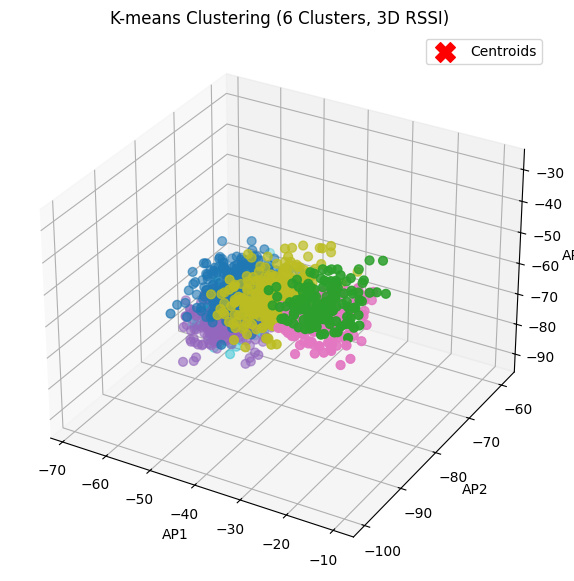

K-means Accuracy: 86.12%


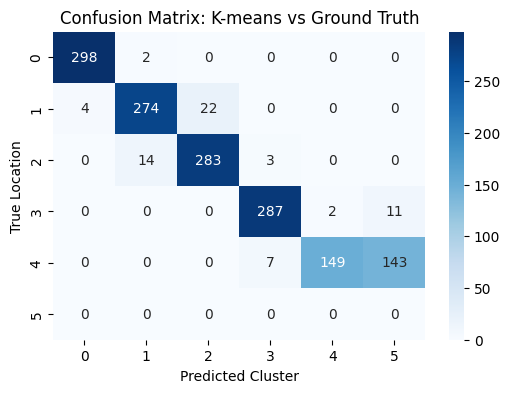

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# --- Data Preparation ---
# Assume rssi_df is already loaded and has columns 'AP1', 'AP2', 'AP3'
X = rssi_df[['AP1', 'AP2', 'AP3']].values
k = 6  # Number of clusters
T = 100  # Max iterations
epsilon = 1e-4  # Convergence threshold

# --- Centroid Initialization (random from data) ---
np.random.seed(42)
centroids = X[np.random.choice(X.shape[0], k, replace=False)]

# --- K-means Algorithm ---
for t in range(T):
    # Assign each point to the closest centroid
    distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    labels = np.argmin(distances, axis=1)

    # Update centroids as the mean of assigned points
    new_centroids = np.array([
        X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
        for i in range(k)
    ])

    # Convergence check: centroids move less than epsilon
    if np.linalg.norm(new_centroids - centroids) < epsilon:
        print(f"Converged after {t+1} iterations.")
        break

    centroids = new_centroids
else:
    print("Reached max iterations without full convergence.")

print("Final Centroids:\n", centroids)

# --- 3D Plot of Cluster Assignments ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='tab10', s=40)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('AP1')
ax.set_ylabel('AP2')
ax.set_zlabel('AP3')
ax.set_title('K-means Clustering (6 Clusters, 3D RSSI)')
plt.legend()
plt.show()

# --- If you have ground-truth labels, you can evaluate accuracy and plot confusion matrix ---
true_labels = labels_df['Location'].astype('category').cat.codes.values

def best_map(true_labels, pred_labels):
    D = max(pred_labels.max(), true_labels.max()) + 1
    cost_matrix = np.zeros((D, D))
    for i in range(D):
        for j in range(D):
            cost_matrix[i, j] = np.sum((pred_labels == i) & (true_labels == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    label_mapping = dict(zip(row_ind, col_ind))
    new_pred = np.array([label_mapping[label] for label in pred_labels])
    return new_pred

mapped_labels = best_map(true_labels, labels)
conf_mat = confusion_matrix(true_labels, mapped_labels)
accuracy = accuracy_score(true_labels, mapped_labels)
print(f"K-means Accuracy: {accuracy*100:.2f}%")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Location")
plt.title("Confusion Matrix: K-means vs Ground Truth")
plt.show()
